# Importing Data

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report
from transformers import XLNetTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import XLNetForSequenceClassification
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
def readCreateDataframe(folder_path : Path, fake: bool = False) -> pd.DataFrame:
    if not folder_path.is_dir():
        raise ValueError("Folder path does not exist")
    data = []
    for file in sorted(folder_path.iterdir()):
        text = file.read_text()
        if fake:
            data.append([text, 1])
        else:
            data.append([text, 0])
    return pd.DataFrame(data, columns=["text", "label"])

In [3]:
df_fake = readCreateDataframe(Path("Data/full_texts/fake"), fake=True)
df_true = readCreateDataframe(Path("Data/full_texts/true"), fake=False)

In [4]:
df = pd.concat([df_fake, df_true], ignore_index=True)
df.reset_index(drop=True, inplace=True)
df = df.sample(frac=1, random_state=461249612).reset_index(drop=True) # to shuffle the data
df

text  label
0      © DPA Se chamar “Fátima” num país avesso ao q...      0
1     Esposa de Lula sofre AVC e está em estado grav...      1
2     Thiago Lacerda solta o verbo: "Artistas defend...      1
3     Barbosa : "Michel Temer não tem legitimidade p...      1
4     Barroso: "Criamos uma sociedade cheia de ricos...      1
...                                                 ...    ...
7195  Festejos ao Dois de Julho reúnem famílias e tê...      0
7196  Candidato Luiz Castro participa de entrevista ...      0
7197  BNDES e FRIBOI: Uma das famílias mais poderosa...      1
7198  Vaquinha virtual da Dona Dilma já conseguiu ar...      1
7199  Psiquiatra emite diagnóstico de Lula: "Persona...      1

[7200 rows x 2 columns]

In [5]:
del df_fake, df_true

# Tokenizing

We will use the pretrained XLNetTokenizer from HugginsFace

In [7]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
inputs_ids = [tokenizer.encode(x, add_special_tokens=True, return_tensors="pt", truncation=True, padding='max_length', max_length=512) for x in df['text']]
inputs_ids

[tensor([[   17,     0,   347,  5896,  2100,    17,  2409,  1880,   221,  7697,
             46,  6109,   407,    17,  8713,    17, 17850,    23,    17, 17272,
           2096,    24,   155,    17,  1895,    17,    93,   221,  1277,  2156,
           2654,   407,    24, 12236,    17, 18714,    23,    17,  1022,    17,
          16838,   221,  1277,  2156,  2654,   407,    17,  7578,   213,    24,
             17,  2013,  2748,    17,  9681,    17,    88,  6657,   780,   155,
           8075,    17, 13853,    19, 11760,    17,  1212,  2483,  1079,    19,
             17,  1022,    17,  1512,  1156,    17,  5023, 10107,    17, 22674,
            721,    19,   321,    78,   986,    17,    93,    22,    98,  4304,
           2748,   155,   221,   101,  3657,   407,    17,    93,   221,  7433,
           6225, 12485,  6536,   407, 11760,    17,  6752,  1841, 17883,    23,
            102,  1937, 10012,    23,    19, 16960,  9059,   712,    17,  1895,
             17,   202, 10564,  9817,   

# Creating the Dataloader

In [9]:
y = df['label'].tolist()
X_train, X_val, y_train, y_val = train_test_split(inputs_ids, y, test_size=0.2, random_state=461249612)

In [12]:
train_dataset = TensorDataset(torch.stack(X_train).squeeze(1), torch.tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Training the model

In [14]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
from tqdm import tqdm
num_epochs = 10
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}')
    
    for batch in progress_bar:
        # Move batch to GPU
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)
        
        # Zero out gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Update progress bar
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{total_loss/(progress_bar.n+1):.4f}'})
    
    avg_loss = total_loss / len(train_dataloader)
    print(f'\nEpoch {epoch + 1} - Average Loss: {avg_loss:.4f}')

Epoch 1: 100%|██████████| 720/720 [14:48<00:00,  1.23s/it, loss=0.2908]



Epoch 1 - Average Loss: 0.2908


Epoch 2: 100%|██████████| 720/720 [15:06<00:00,  1.26s/it, loss=0.0935]



Epoch 2 - Average Loss: 0.0935


Epoch 3: 100%|██████████| 720/720 [15:10<00:00,  1.26s/it, loss=0.0561]



Epoch 3 - Average Loss: 0.0561


Epoch 4: 100%|██████████| 720/720 [15:19<00:00,  1.28s/it, loss=0.0383]



Epoch 4 - Average Loss: 0.0383


Epoch 5: 100%|██████████| 720/720 [15:18<00:00,  1.28s/it, loss=0.0254]



Epoch 5 - Average Loss: 0.0254


Epoch 6: 100%|██████████| 720/720 [15:23<00:00,  1.28s/it, loss=0.0240]



Epoch 6 - Average Loss: 0.0240


Epoch 7: 100%|██████████| 720/720 [15:23<00:00,  1.28s/it, loss=0.0165]



Epoch 7 - Average Loss: 0.0165


Epoch 8: 100%|██████████| 720/720 [15:24<00:00,  1.28s/it, loss=0.0166]



Epoch 8 - Average Loss: 0.0166


Epoch 9: 100%|██████████| 720/720 [15:22<00:00,  1.28s/it, loss=0.0041]



Epoch 9 - Average Loss: 0.0041


Epoch 10: 100%|██████████| 720/720 [15:21<00:00,  1.28s/it, loss=0.0139]


Epoch 10 - Average Loss: 0.0139


Text(0, 0.5, 'Average Loss')

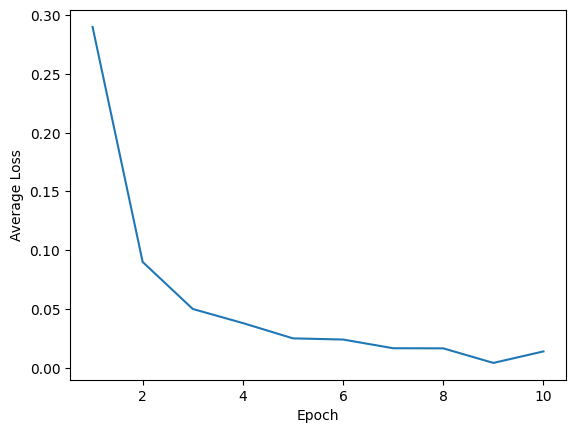

In [5]:
avg_loss = [0.29, 0.09, 0.05, 0.038, 0.025, 0.024, 0.0166, 0.0165, 0.0041, 0.0139]
plt.plot(range(1, 11), avg_loss)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")

In [19]:
model.save_pretrained("XLNet_retrained")

# Testing the Results

In [14]:
test_dataloader = DataLoader(TensorDataset(torch.stack(X_val).squeeze(1), torch.tensor(y_val)), batch_size=8, shuffle=False)

In [15]:
model = XLNetForSequenceClassification.from_pretrained("XLNet_retrained")  # Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(input_ids, labels=labels)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

In [16]:
report = classification_report(y_true, y_pred, target_names=["Fake", "Real"])
print(report)   

              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98       716
        Real       0.98      0.98      0.98       724

    accuracy                           0.98      1440
   macro avg       0.98      0.98      0.98      1440
weighted avg       0.98      0.98      0.98      1440

